# EEG motor imagery classification using ICA
#### Author - Alon Ben-Arieh
In this project we've used ICA to extract valuable information from EEG signals.

The main stages of the projects are:
1. Apply ICA on the data
2. Use Naive Bayes classifiers to find which ICs are meaningful and informative.
3. Reconstruct the electrodes data only from the informative ICs.
4. Feed Igor's CNN with the reconstructed data.

The project was done under the supervision of Miri Binyamini.

In [1]:
from datetime import date
import numpy as np
import mne as mne
import matplotlib.pyplot as plt

# Define constants
ELECTRODES_NUM = 35

# Define data import and export folders paths
today = date.today().strftime("%b-%d-%Y")
month = date.today().strftime("%B")
root_folder = f"../data/{month}/{today}"
matlab_data_folder = "../data/reut-matlab"

## ICA fitting and applying

In [2]:
# Fetch the data from the .set file
base_removed_eeglab_epochs = mne.io.read_epochs_eeglab(matlab_data_folder + '/base_removed_short_35_electrodes_filtered_epoched_locations.set')
eeglab_epochs = mne.io.read_epochs_eeglab(matlab_data_folder + '/short_35_electrodes_filtered_epoched_locations.set')

# Trim the data
trimmed_base_removed_eeglab_epochs = base_removed_eeglab_epochs.copy().crop(tmin=0.1, tmax=0.8)
trimmed_eeglab_epochs = eeglab_epochs.copy().crop(tmin=0.1, tmax=0.8)

# Create the train set and test set
total_num_of_epochs = len(eeglab_epochs)

train_set_indexes = []
test_set_indexes = []
for i in range(total_num_of_epochs):
    random_num = np.random.rand()
    if (random_num < 0.8):  # 80% chance of being here
        train_set_indexes.append(i)
    else:
        test_set_indexes.append(i)

train_set = trimmed_eeglab_epochs[train_set_indexes]
test_set = trimmed_eeglab_epochs[test_set_indexes]
base_removed_train_set = trimmed_base_removed_eeglab_epochs[train_set_indexes]
base_removed_test_set = trimmed_base_removed_eeglab_epochs[test_set_indexes]

print(f"Total number of Epochs: {total_num_of_epochs}")
print(f"Train set size: {len(train_set)}. Left: {len(train_set['Left'].selection)} Right: {len(train_set['Right'].selection)} No Move: {len(train_set['NoMove'].selection)}")
print(f"Test set size: {len(test_set)}. Left: {len(test_set['Left'].selection)} Right: {len(test_set['Right'].selection)} No Move: {len(test_set['NoMove'].selection)}")

Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\EEG-classification\production\..\data\reut-matlab\base_removed_short_35_electrodes_filtered_epoched_locations.set...
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from c:\Users\alonb\OneDrive - Technion\טכניון\סמסטר ט' - אביב 2022\פרוייקט א\EEG-classification\production\..\data\reut-matlab\short_35_electrodes_filtered_epoched_locations.set...
Not setting metadata
440 matching events found
No baseline correction applied
0 projection items activated
Ready.
Total number of Epochs: 440
Train set size: 337. Left: 112 Right: 118 No Move: 107
Test set size: 103. Left: 26 Right: 35 No Move: 42


In [3]:
# Fit ICA on the data that was NOT baseline removed
ica = mne.preprocessing.ICA(n_components = ELECTRODES_NUM, method='picard')
ica.fit(train_set)

Fitting ICA to data using 35 channels (please be patient, this may take a while)


C:\Users\alonb\AppData\Local\Temp\ipykernel_21496\2688277674.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(train_set)


Selecting by number: 35 components
Fitting ICA took 21.2s.


<ICA | epochs decomposition, method: picard (fit in 88 iterations on 118287 samples), 35 ICA components explaining 100.0 % of variance (35 PCA components available), channel types: eeg, no sources marked for exclusion>

In [4]:
# Apply the ICA on the baseline removed data
train_ICs = ica.get_sources(base_removed_train_set)
test_ICs = ica.get_sources(base_removed_test_set)

# Extract the data and labels from the MNE EEG objects
train_data = np.swapaxes(train_ICs.copy().get_data(), 0, 1)
test_data = np.swapaxes(test_ICs.copy().get_data(), 0, 1)
train_labels = train_ICs.events[:,2]
test_labels = test_ICs.events[:,2]

## ICs rating with NB classifiers

The average accuracy is 0.436.
The average F1 score is 0.427.


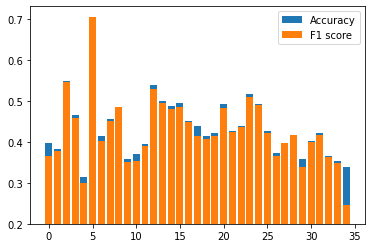

In [5]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.naive_bayes import GaussianNB

# Train the classifiers
f1_scores = []
accuracy_scores = []
predictions = []
for i in range(ELECTRODES_NUM):
    clf = GaussianNB()
    predictions.append(cross_val_predict(clf, train_data[i], train_labels))
    f1_scores.append(cross_val_score(clf, train_data[i], train_labels, scoring='f1_macro').mean())
    accuracy_scores.append(cross_val_score(clf, train_data[i], train_labels).mean())

# Print the mean accuracy and F1 scores, among all ICs
f1_scores = np.array(f1_scores)
accuracy_scores = np.array(accuracy_scores)
print(f"The average accuracy is {round(accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(f1_scores.mean(),3)}.")

# Plot the ICs performance
bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

In [10]:
# Apply a threshold on the ICs
acc_thresh = 0.5
f1_thresh = acc_thresh - 0.02
chosen_idxs_by_acc = np.where(accuracy_scores > acc_thresh)
chosen_idxs_by_f1 = np.where(f1_scores > f1_thresh)
chosen_idxs = tuple(np.intersect1d(chosen_idxs_by_acc, chosen_idxs_by_f1))
print(chosen_idxs)

# Reconstruct the electrodes from the chosen ICs 
reconstructed_from_best_train_ICs = ica.apply(base_removed_train_set.copy(), include=chosen_idxs)
reconstructed_from_best_test_ICs = ica.apply(base_removed_test_set.copy(), include=chosen_idxs)

(2, 5, 12, 13, 23)
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 30 ICA components
    Projecting back using 35 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (35 components)
    Zeroing out 30 ICA components
    Projecting back using 35 PCA components


The average accuracy is 0.425.
The average F1 score is 0.414.


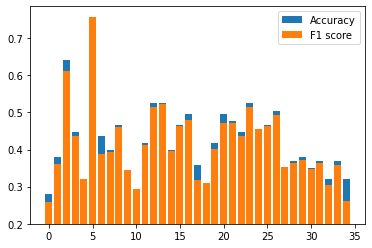

In [11]:
from sklearn.metrics import accuracy_score, f1_score

# Check the classifiers performance on the test data
eval_f1_scores = []
eval_accuracy_scores = []
for i in range(ELECTRODES_NUM):
    clf = GaussianNB()
    clf.fit(train_data[i], train_labels)
    prediction = clf.predict(test_data[i])
    eval_accuracy_scores.append(accuracy_score(test_labels, prediction))
    eval_f1_scores.append(f1_score(test_labels, prediction, average='macro'))

eval_f1_scores = np.array(eval_f1_scores) 
eval_accuracy_scores = np.array(eval_accuracy_scores) 
print(f"The average accuracy is {round(eval_accuracy_scores.mean(),3)}.")
print(f"The average F1 score is {round(eval_f1_scores.mean(),3)}.")


bottom = 0.2
x = np.arange(ELECTRODES_NUM)
plt.bar(x, eval_accuracy_scores-bottom, bottom=bottom, label="Accuracy")
plt.bar(x, eval_f1_scores-bottom, bottom=bottom, label="F1 score")
plt.legend();

## Topomaps and plots in time

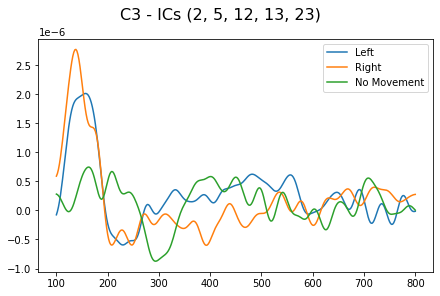

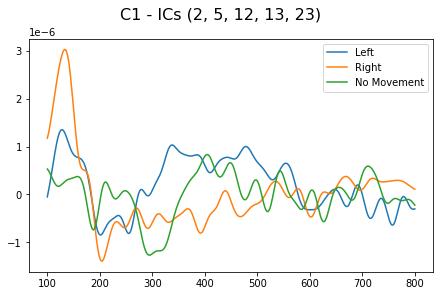

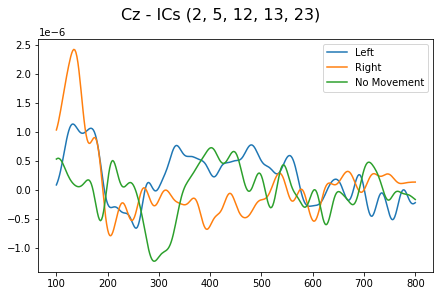

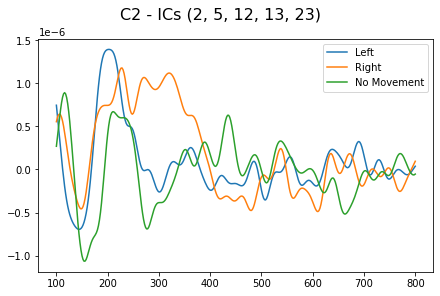

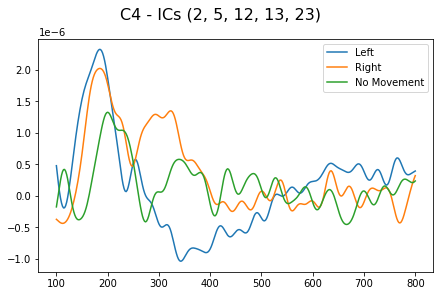

In [12]:
# Plot the center electrodes in time
time_axis = reconstructed_from_best_train_ICs.times * 1000
channel_names = [['C3'], ['C1'], ['Cz'], ['C2'], ['C4']]
for channel_name in channel_names:
    fig, ax = plt.subplots(nrows = 1, ncols = 1, constrained_layout = True)
    fig.suptitle(f"{channel_name[0]} - ICs {chosen_idxs}", fontsize = 16)
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Left"].average().pick_channels(channel_name).get_data()), label='Left')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["Right"].average().pick_channels(channel_name).get_data()), label='Right')
    ax.plot(time_axis, np.squeeze(reconstructed_from_best_train_ICs["NoMove"].average().pick_channels(channel_name).get_data()), label='No Movement')
    ax.legend()

C:\Users\alonb\AppData\Local\Temp\ipykernel_21496\2338623569.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows = 3, ncols = TIME_POINTS_NUM, constrained_layout=True)


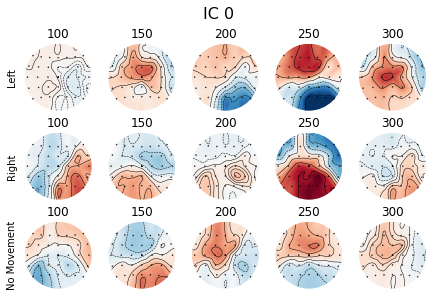

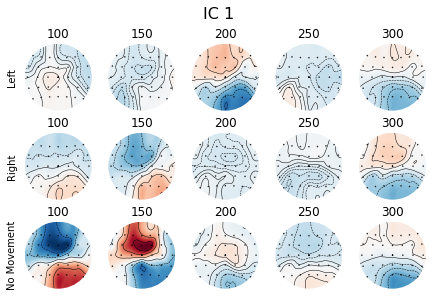

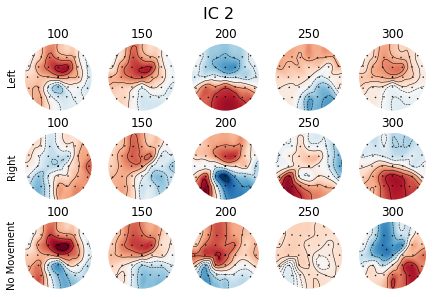

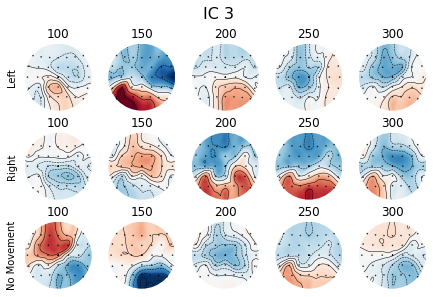

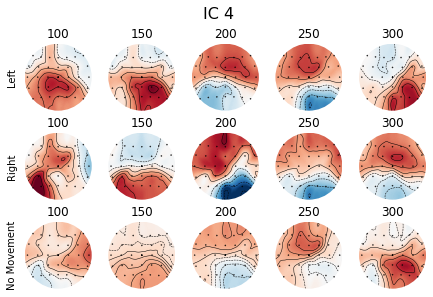

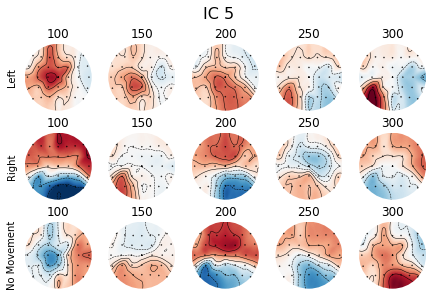

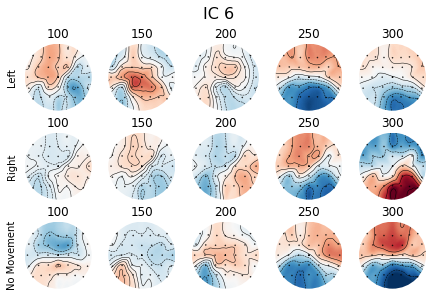

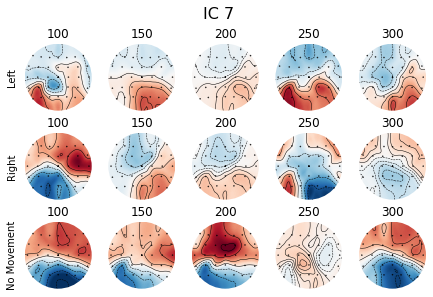

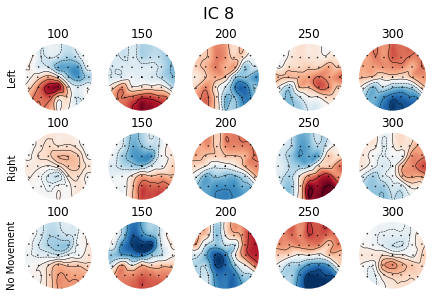

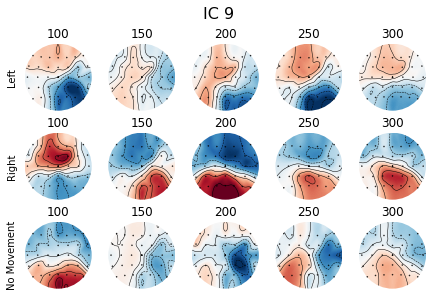

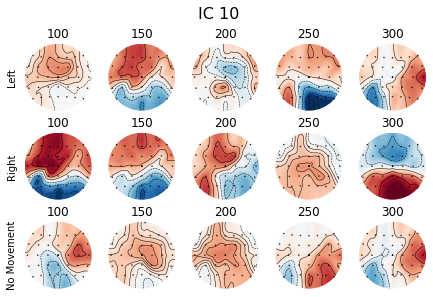

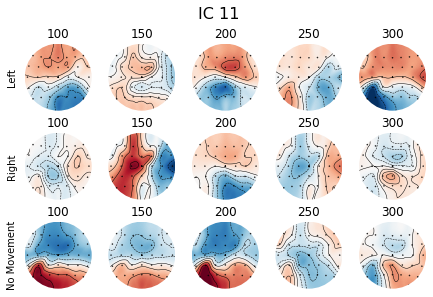

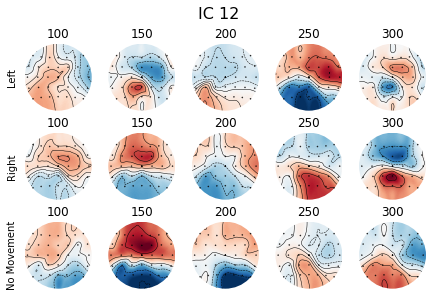

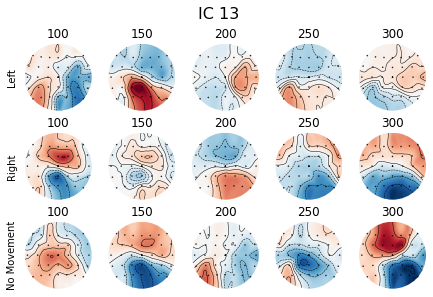

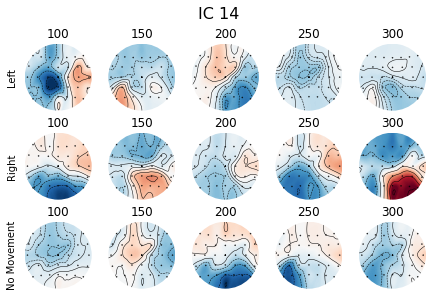

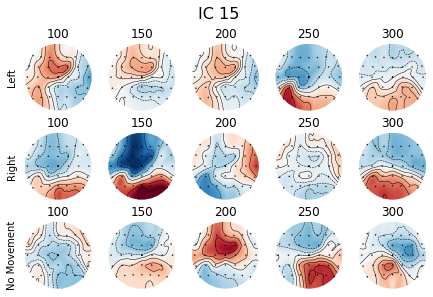

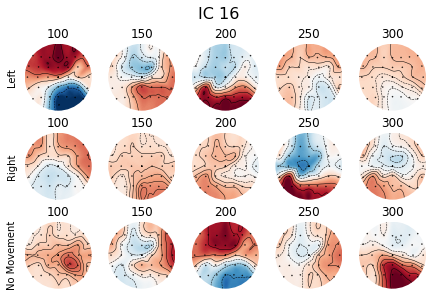

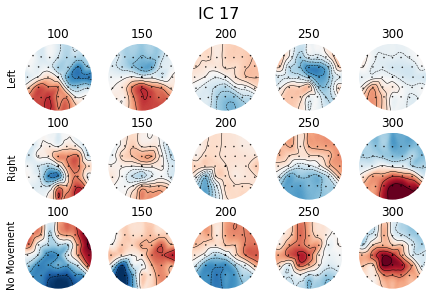

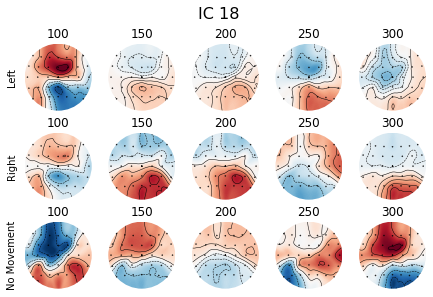

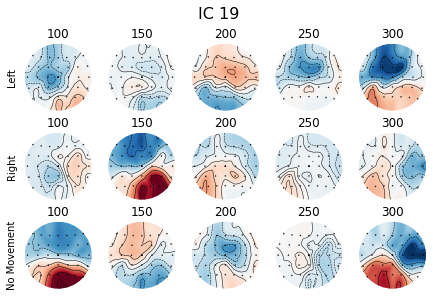

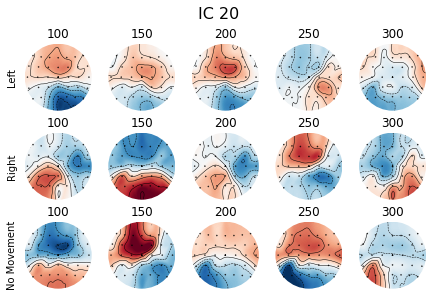

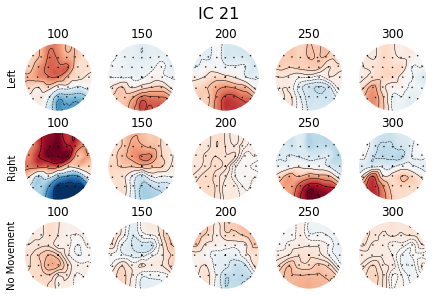

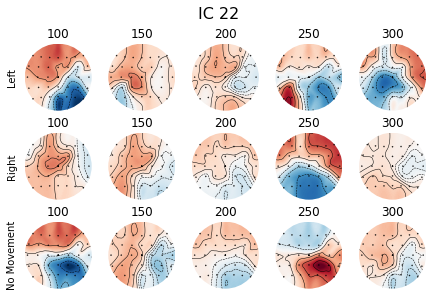

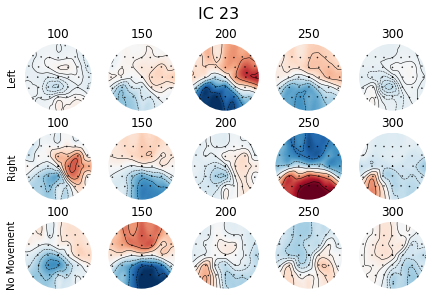

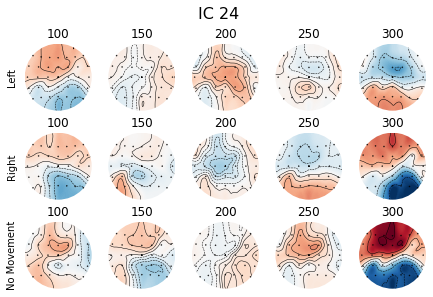

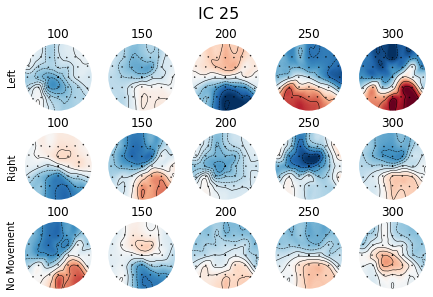

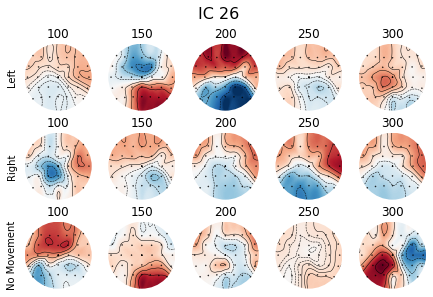

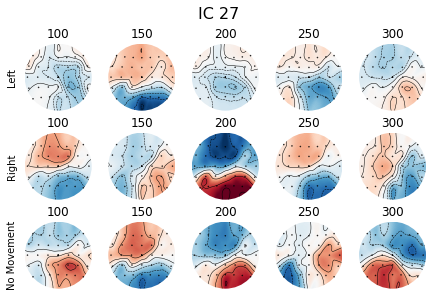

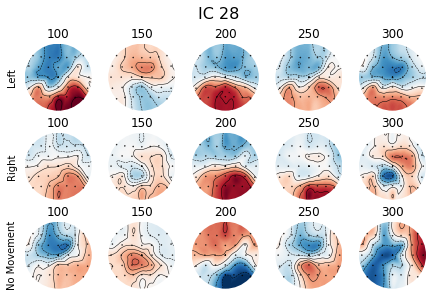

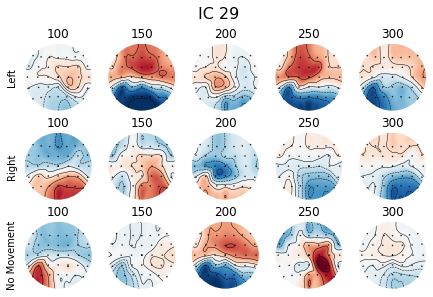

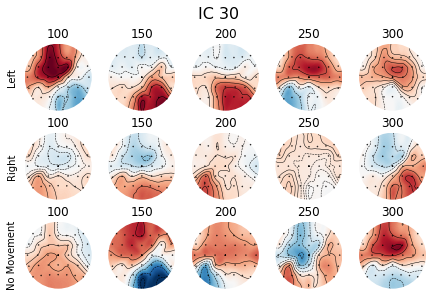

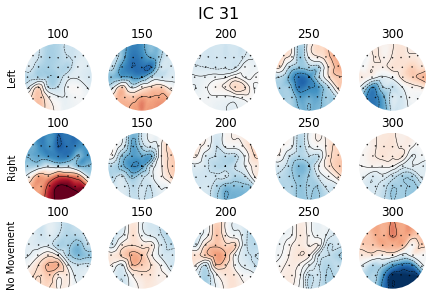

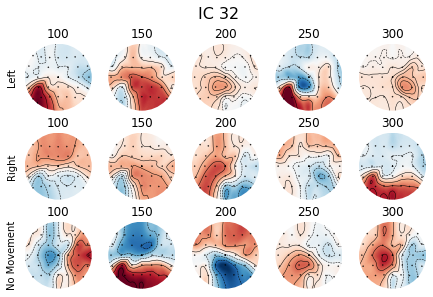

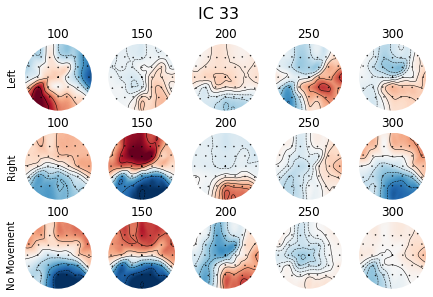

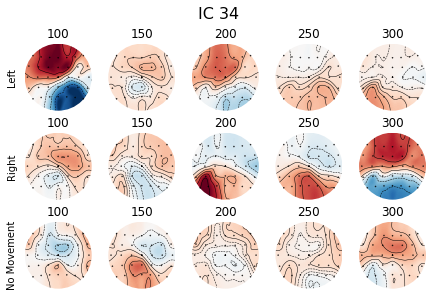

In [13]:
# Plot topomaps of all the ICs

train_left_reconstructed = reconstructed_from_best_train_ICs["Left"].get_data()
train_right_reconstructed = reconstructed_from_best_train_ICs["Right"].get_data()
train_no_move_reconstructed = reconstructed_from_best_train_ICs["NoMove"].get_data()

TIME_POINTS_NUM = 5

for ic in range(ELECTRODES_NUM):
    fig, ax = plt.subplots(nrows = 3, ncols = TIME_POINTS_NUM, constrained_layout=True)
    fig.suptitle(f"IC {ic}", fontsize=16)
    ax[0,0].set_ylabel('Left')
    ax[1,0].set_ylabel('Right')
    ax[2,0].set_ylabel('No Movement')
    time_points = np.arange(start=100, stop=301, step=50)
    voltages = [train_left_reconstructed[ic,:,time_points],
                train_right_reconstructed[ic,:,time_points],
                train_no_move_reconstructed[ic,:,time_points]]
    v_min = np.min(voltages)
    v_max = np.max(voltages)
    for time_point_idx in range(TIME_POINTS_NUM):
        time_point = time_points[time_point_idx]
        mne.viz.plot_topomap(train_left_reconstructed[ic,:,time_point], reconstructed_from_best_train_ICs["Left"].info, vmin=v_min, vmax=v_max, axes=ax[0,time_point_idx], show=False)
        ax[0,time_point_idx].set_title(str(time_point))
        mne.viz.plot_topomap(train_right_reconstructed[ic,:,time_point], reconstructed_from_best_train_ICs["Right"].info, vmin=v_min, vmax=v_max, axes=ax[1,time_point_idx], show=False)
        ax[1,time_point_idx].set_title(str(time_point))
        mne.viz.plot_topomap(train_no_move_reconstructed[ic,:,time_point], reconstructed_from_best_train_ICs["NoMove"].info, vmin=v_min, vmax=v_max, axes=ax[2,time_point_idx], show=False)
        ax[2,time_point_idx].set_title(str(time_point))

## CNN

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Wrapper functions
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield tuple(prod)

def plot_confusion_matrix(cm, class_names,flag, is_test = False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    dataset_name = 'Test set' if is_test else 'Validation set'
    plt.title(f"Confusion matrix - {dataset_name}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm_norm.max() / 2.
    
    for i, j in product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        color = "white" if cm_norm[i, j] > 0.34 else "black"
        plt.text(j, i, '({:.0f}%)\n {}'.format(cm_norm[i, j]*100, cm[i,j]), horizontalalignment="center", color=color, linespacing=3, fontsize='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def one_hot_encoder(labels, classes_num = 3):
    epochs_num = labels.shape[0]
    labels_onehot = np.zeros((epochs_num, classes_num))
    for i in range(epochs_num):
        labels_onehot[i, int(labels[i]-1)] = 1
    return labels_onehot

def print_confusion_matrix(model, data, true_labels_onehot, is_test = False):
    ###### Evaluation
    prediction = model.predict(data)
    y_hat = np.zeros(np.shape(true_labels_onehot))
    for i in range(np.shape(y_hat)[0]):
        y_hat[i,np.argmax(prediction[i,:])] = 1
    delta = np.sum(abs(y_hat - true_labels_onehot), axis=1)
    accuracy = len(delta[delta==0])/len(delta)*100
    if is_test:
        print(f"Accuracy: {round(accuracy, 2)}")
    
    # Calculating Confusion Matrix
    y_pred = np.argmax(y_hat, axis=1)
    y_true = np.argmax(true_labels_onehot, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    
    class_names=["Right","Left","No Movement"]
    figure = plot_confusion_matrix(cm, class_names=class_names, flag=1, is_test=is_test)

In [15]:
# Rename the data
train_val_set = base_removed_train_set
test_set = base_removed_test_set

# Create labels
train_val_labels = train_val_set.events[:,2]
test_labels = test_set.events[:,2]

print(train_val_labels.shape)
print(test_labels.shape)

(337,)
(103,)


In [16]:
# Reshape data to 5x7 matrix
electrodes_names_grid = np.array([
    ['F5','F3','F1','Fz','F2','F4','F6'],
    ['FC5','FC3','FC1','FCz','FC2','FC4','FC6'],
    ['C5','C3','C1','Cz','C2','C4','C6'],
    ['CP5','CP3','CP1','CPz','CP2','CP4','CP6'],
    ['P5','P3','P1','Pz','P2','P4','P6']
])
ROW_NUM, COL_NUM = electrodes_names_grid.shape
TIME_SAMPLES_NUM = train_val_set.times.shape[0]
TRAIN_VAL_EPOCHS_NUM = train_val_set.selection.shape[0]
TEST_EPOCHS_NUM = test_set.selection.shape[0]

train_val_data = np.empty((ROW_NUM, COL_NUM, TRAIN_VAL_EPOCHS_NUM, TIME_SAMPLES_NUM))
test_data = np.empty((ROW_NUM, COL_NUM, TEST_EPOCHS_NUM, TIME_SAMPLES_NUM))

for i in range(ROW_NUM):
    for j in range(COL_NUM):
        channel_name = [electrodes_names_grid[i,j]]
        train_val_data[i,j,:,:] = np.squeeze(train_val_set.copy().pick_channels(channel_name).get_data())
        test_data[i,j,:,:] = np.squeeze(test_set.copy().pick_channels(channel_name).get_data())
        
train_val_data = np.moveaxis(train_val_data, 2, 0) * (10**6)
test_data = np.moveaxis(test_data, 2, 0) * (10**6)

# A regular CNN for an image recieves 3 channels - RGB.
# This CNN is 3D: 2D matrix, 1D time.
# We add another dimension for explicitly stating using 1 channel, like the image's 3 channels.
train_val_data = np.expand_dims(train_val_data, axis=4)
test_data = np.expand_dims(test_data, axis=4)

# Encoding the events as one-hot vectors
train_val_labels_onehot = one_hot_encoder(train_val_labels)
test_labels_onehot = one_hot_encoder(test_labels)

# Shuffle and split the data
train_val_data_shuffled, train_val_labels_onehot_shuffled = shuffle(train_val_data, train_val_labels_onehot, random_state=123)
train_data, val_data, train_labels_onehot, val_labels_onehot = train_test_split(train_val_data_shuffled, train_val_labels_onehot_shuffled, test_size=0.1, random_state=123, stratify=train_val_labels_onehot_shuffled)

print(train_data.shape)
print(train_labels_onehot.shape)
print(val_data.shape)
print(val_labels_onehot.shape)
print(test_data.shape)
print(test_labels_onehot.shape)

(303, 5, 7, 351, 1)
(303, 3)
(34, 5, 7, 351, 1)
(34, 3)
(103, 5, 7, 351, 1)
(103, 3)


In [17]:
# Build the NN
model = keras.Sequential([
    layers.Conv3D(20, (3,3,200), padding='valid', input_shape=(5, 7, TIME_SAMPLES_NUM, 1), activation="relu"),
    layers.Conv3D(10, (2,2,20), padding='valid', activation="relu"),
    layers.MaxPooling3D((2, 2, 50), strides=(1,1,50)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(3, activation="softmax")
])

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 5, 152, 20)     36020     
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 4, 133, 10)     16010     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 3, 2, 10)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 1, 3, 2, 10)      40        
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [18]:
# Train the model
history = model.fit(train_data, train_labels_onehot, epochs=10, validation_data=(val_data, val_labels_onehot))

Epoch 1/10
10/10 [==============================] - 15s 1s/step - loss: 1.2760 - accuracy: 0.4323 - val_loss: 2.8427 - val_accuracy: 0.4706
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 0.7374 - accuracy: 0.6535 - val_loss: 2.5653 - val_accuracy: 0.4706
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 0.5930 - accuracy: 0.7723 - val_loss: 1.8115 - val_accuracy: 0.5882
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.4702 - accuracy: 0.8812 - val_loss: 1.3767 - val_accuracy: 0.6176
Epoch 5/10
10/10 [==============================] - 9s 900ms/step - loss: 0.3612 - accuracy: 0.9274 - val_loss: 1.3999 - val_accuracy: 0.5294
Epoch 6/10
10/10 [==============================] - 10s 965ms/step - loss: 0.2774 - accuracy: 0.9736 - val_loss: 1.1600 - val_accuracy: 0.5882
Epoch 7/10
10/10 [==============================] - 10s 987ms/step - loss: 0.2103 - accuracy: 0.9934 - val_loss: 1.1253 - val_accuracy: 0.5588
Epoch 8/10
1

Max val accuracy: 67.65
4/4 [==============================] - 0s 108ms/step
Accuracy: 55.34


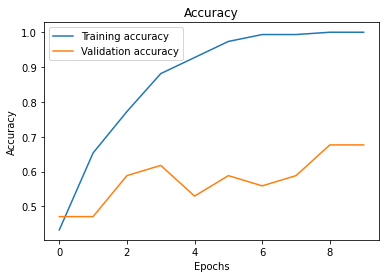

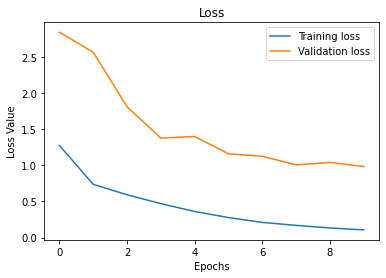

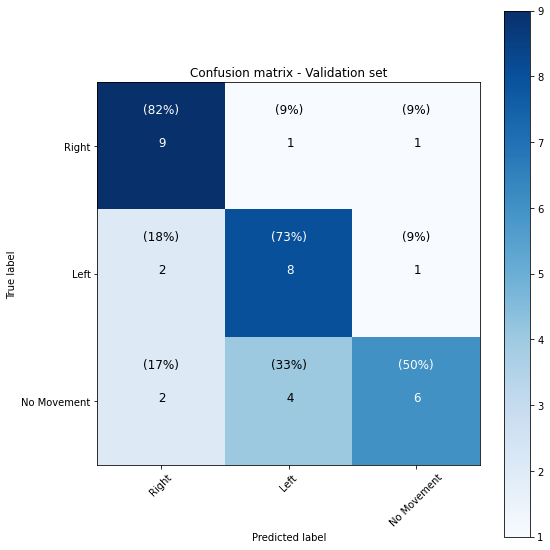

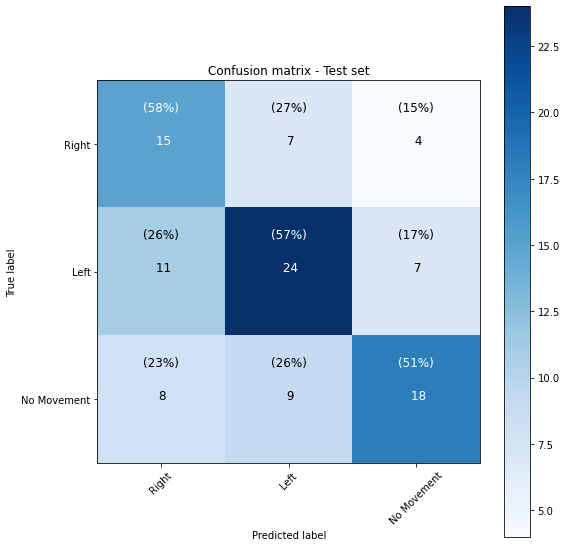

In [19]:
# Plot Accuracy graph (train set and val set)
metrics_df = pd.DataFrame(history.history)
ax = metrics_df[["accuracy", "val_accuracy"]].plot(title="Accuracy");
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy")
ax.legend(["Training accuracy", "Validation accuracy"]);

# Plot Loss graph (train set and val set)
axe = metrics_df[["loss", "val_loss"]].plot(title="Loss");
axe.set_xlabel("Epochs")
axe.set_ylabel("Loss Value")
axe.set_title("Loss")
axe.legend(["Training loss", "Validation loss"]);

print(f"Max val accuracy: {round(metrics_df.val_accuracy.max() * 100, 2)}")
print_confusion_matrix(model, val_data, val_labels_onehot)

# Test set confusion matrix
print_confusion_matrix(model, test_data, test_labels_onehot, is_test = True)